In [1]:
import cv2
import time
import os
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
labels = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [4]:
# Load classification model

CNN_model = keras.models.load_model('/content/gdrive/MyDrive/AV_seminar/Classification/first_model_trial/model_with_dropout_9741.h5')
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                    

In [5]:
print(os.getcwd())
path = '/content/gdrive/MyDrive/AV_seminar/Detection/YOLOv4/darknet'
os.chdir(path)
print(os.getcwd())

/content
/content/gdrive/MyDrive/AV_seminar/Detection/YOLOv4/darknet


In [6]:
print(cv2.__version__)

3.4.13


In [1]:
# Install version 3.4.13 that supports "readNetFromDarknet" function

!pip install opencv-contrib-python==3.4.13.47 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53.7 MB 234 kB/s 
     |████████████████████████████████| 15.7 MB 34.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [7]:
# Load detection model (YOLOv4) weights and cfg files

YOLOv4_weights_path = 'yolov4-TF_train_best.weights'
YOLOv4_test_cfg_path = 'cfg/yolov4-TF_test.cfg'

YOLO_network = cv2.dnn.readNetFromDarknet(YOLOv4_test_cfg_path, YOLOv4_weights_path)
YOLO_network.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
YOLO_network.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL_FP16)

In [8]:
layers_all = YOLO_network.getLayerNames()
layers_names_output = [layers_all[i[0] - 1] for i in YOLO_network.getUnconnectedOutLayers()]
print(layers_names_output) 

['yolo_139', 'yolo_150', 'yolo_161']


In [9]:
# Minimum probability to eliminate weak detections
probability_minimum = 0.2
# Setting threshold to filtering weak bounding boxes by non-maximum suppression
threshold = 0.2

# Generating colours for bounding boxes
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')
print(type(colours)) 
print(colours.shape)  
print(colours[0]) 

<class 'numpy.ndarray'>
(43, 3)
[199  80 123]


In [13]:
# Reading video from a file by VideoCapture object

video = cv2.VideoCapture('/content/gdrive/MyDrive/AV_seminar/Detection/YOLOv4/test_data/traffic-sign-to-test.mp4')

# Writer that will be used to write processed frames
writer = None

# Variables for spatial dimensions of the frames
h, w = None, None

In [14]:
from PIL import Image

def image_preprocessing(image):
  image_fromarray = Image.fromarray(image)
  resize_image = image_fromarray.resize((32, 32))
  image_as_numpy_array = np.array(resize_image)
  image_gray = np.sum(image_as_numpy_array/3, axis = 2, keepdims = True)
  image_gray_norm = image_gray/255.0

  return image_gray_norm


def image_gray(image):
  image_gray = np.sum(image/3, axis = 2, keepdims = True)
  
  return image_gray


In [15]:
%matplotlib inline

# Setting default size of plots
plt.rcParams['figure.figsize'] = (3, 3)

# Variable for counting total amount of frames
f = 0

# Variable for counting total processing time
t = 0

# Catching frames in the loop
while True:
    # Capturing frames one-by-one
    ret, frame = video.read()
    copied_frame = frame

    # If the frame was not retrieved
    if not ret:
        break
       
    # Getting spatial dimensions of the frame for the first time
    if w is None or h is None:
        # Slicing two elements from tuple
        h, w = frame.shape[:2]

    # Blob from current frame
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)

    # Forward pass with blob through output layers
    YOLO_network.setInput(blob)
    start = time.time()
    output_from_network = YOLO_network.forward(layers_names_output)
    end = time.time()

    # Increasing counters
    f += 1
    t += end - start

    # Spent time for current frame
    print('Frame number {0} took {1:.5f} seconds'.format(f, end - start))

    # Lists for detected bounding boxes, confidences and class's number
    bounding_boxes = []
    confidences = []
    class_numbers = []

    # Going through all output layers after feed forward pass
    for result in output_from_network:
        # Going through all detections from current output layer
        for detected_objects in result:
            # Getting 80 classes' probabilities for current detected object
            scores = detected_objects[5:]
            # Getting index of the class with the maximum value of probability
            class_current = np.argmax(scores)
            # Getting value of probability for defined class
            confidence_current = scores[class_current]

            # Eliminating weak predictions by minimum probability
            if confidence_current > probability_minimum:
                # Scaling bounding box coordinates to the initial frame size
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                # Getting top left corner coordinates
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                # Adding results into prepared lists
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
                

    # Implementing non-maximum suppression of given bounding boxes
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    # Checking if there is any detected object been left
    if len(results) > 0:
        # Going through indexes of results
        for i in results.flatten():
            # Bounding box coordinates, its width and height
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            
            # Cut fragment with Traffic Sign
            c_ts = frame[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
            # print(c_ts.shape)
            # print(type(c_ts))
            
            if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
                pass
            else:
                
                # Getting preprocessed the cropped part with Traffic Sign of needed shape
                
                crop_img = cv2.resize(c_ts, (32, 32))
                crop_img = crop_img/255.0
                crop_img = image_gray(crop_img)
                crop_img =  crop_img.reshape(-1, 32,32,1)


                
                # print("preprocessed_image: {}".format(crop_img.shape))
                # Feeding to the Keras CNN model to get predicted label among 43 classes
                scores = CNN_model.predict(crop_img)

                # Scores is given for image with 43 numbers of predictions for each class
                # Getting only one class with maximum value
                prediction = np.argmax(scores)
                # print(labels['SignName'][prediction])


                # Colour for current bounding box
                colour_box_current = colours[class_numbers[i]].tolist()

                # Drawing bounding box on the original current frame
                cv2.rectangle(copied_frame, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 2)

                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format(labels[prediction],
                                                       confidences[i])

                # Putting text with label and confidence on the original image
                cv2.putText(copied_frame, text_box_current, (x_min, y_min - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 2)


    # Initializing writer only once
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')

        # Writing current processed frame into the video file
        writer = cv2.VideoWriter('/content/gdrive/MyDrive/AV_seminar/Detection/YOLOv4/test_data/pred/after_copied_frame.mp4', fourcc, 25,
                                 (copied_frame.shape[1], copied_frame.shape[0]), True)

    # Write processed current frame to the file
    writer.write(copied_frame)


# Releasing video reader and writer
video.release()
writer.release()

Frame number 1 took 0.35607 seconds
Frame number 2 took 0.29483 seconds
Frame number 3 took 0.26418 seconds
Frame number 4 took 0.27488 seconds
Frame number 5 took 0.26950 seconds
Frame number 6 took 0.26596 seconds
Frame number 7 took 0.26241 seconds
Frame number 8 took 0.26728 seconds
Frame number 9 took 0.26364 seconds
Frame number 10 took 0.26637 seconds
Frame number 11 took 0.26423 seconds
Frame number 12 took 0.26466 seconds
Frame number 13 took 0.26675 seconds
Frame number 14 took 0.26702 seconds
Frame number 15 took 0.26651 seconds
Frame number 16 took 0.26696 seconds
Frame number 17 took 0.26793 seconds
Frame number 18 took 0.26244 seconds
Frame number 19 took 0.26437 seconds
Frame number 20 took 0.26433 seconds
Frame number 21 took 0.26418 seconds
Frame number 22 took 0.26696 seconds
Frame number 23 took 0.26409 seconds
Frame number 24 took 0.26483 seconds
Frame number 25 took 0.26477 seconds
Frame number 26 took 0.26390 seconds
Frame number 27 took 0.26811 seconds
Frame numb

In [17]:
print('Total number of frames', f)
print('Total amount of time {:.5f} seconds'.format(t))
print('Frames Per Second:', round((f / t), 1))

Total number of frames 56
Total amount of time 15.03085 seconds
Frames Per Second: 3.7


Image shape: (865, 1726, 3)
Image height=865 and width=1726


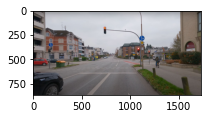

In [18]:
image_BGR = cv2.imread('/content/gdrive/MyDrive/AV_seminar/Detection/YOLOv4/test_data/25.JPG')
# Showing image shape
print('Image shape:', image_BGR.shape)

# Getting spatial dimension of input image
h, w = image_BGR.shape[:2]  # Slicing from tuple only first two elements

# Check point
# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w)) 
plt.imshow(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))

In [19]:
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Variable for counting total processing time
t = 0

# Blob from current frame
blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Forward pass with blob through output layers
YOLO_network.setInput(blob)
start = time.time()
output_from_network = YOLO_network.forward(layers_names_output)
end = time.time()

# Time
t += end - start
print('Total amount of time {:.5f} seconds'.format(t))

# Lists for detected bounding boxes, confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []

# Going through all output layers after feed forward pass
for result in output_from_network:
    # Going through all detections from current output layer
    for detected_objects in result:
        # Getting 80 classes' probabilities for current detected object
        scores = detected_objects[5:]
        # Getting index of the class with the maximum value of probability
        class_current = np.argmax(scores)
        # Getting value of probability for defined class
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial frame size
            box_current = detected_objects[0:4] * np.array([w, h, w, h])

            # Getting top left corner coordinates
            x_center, y_center, box_width, box_height = box_current
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)
                

# Implementing non-maximum suppression of given bounding boxes
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Checking if there is any detected object been left
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Bounding box coordinates, its width and height
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            
        # Cut fragment with Traffic Sign
        c_ts = image_BGR[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
        # print(c_ts.shape)
            
        if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
            pass
        else:
            # Getting preprocessed blob with Traffic Sign of needed shape
            blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
            blob_ts[0] = blob_ts[0, :, :, :]
            blob_ts = blob_ts.transpose(0, 2, 3, 1)
            ###########
            blob_tscc_gray = np.sum(blob_ts/3, axis = 3, keepdims = True)
            ###########
            # plt.imshow(blob_ts[0, :, :, :])
            # plt.show()

            # Feeding to the Keras CNN model to get predicted label among 43 classes
            scores = CNN_model.predict(blob_tscc_gray)

            # Scores is given for image with 43 numbers of predictions for each class
            # Getting only one class with maximum value
            prediction = np.argmax(scores)
            print(labels[prediction])
            print("Class: {}".format(prediction))


            # Colour for current bounding box
            colour_box_current = colours[class_numbers[i]].tolist()

            # Drawing bounding box on the original current frame
            cv2.rectangle(image_BGR, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 2)

            # Preparing text with label and confidence for current bounding box
            text_box_current = '{}: {:.4f}'.format(labels[prediction],
                                                   confidences[i])
            
            # Putting text with label and confidence on the original image
            # cv2.putText(image_BGR, text_box_current, (x_min, y_min-5),
            #                 cv2.FONT_HERSHEY_DUPLEX, .6, [255, 255, 255], 2)
            cv2.putText(image_BGR, text_box_current, (x_min, y_min-5),
                            cv2.FONT_HERSHEY_DUPLEX, 0.6, colour_box_current, 2)
                           
# Saving image
cv2.imwrite('/content/gdrive/MyDrive/AV_seminar/Detection/YOLOv4/test_data/pred/25.jpg', image_BGR)


Total amount of time 0.37053 seconds
Go straight or right
Class: 36
No vehicles
Class: 15
Go straight or right
Class: 36
Priority road
Class: 12


True